## Курсовая работа "Введение в нейронные сети".

1. Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

   - Для выполнения задания курсовой работы, выполним обучение нейронных сетей архитектур: MobileNetV2, ResNet50 и Xception, на датасете Imagenette. Обучение нейронных сетей выполним с применением аугментации и метода Transfer learning, при котором в качестве base_model будем использовать предобученные модели (weights='imagenet') этих же архитектур. Также для base_model применим и расмотрим оба варианта .trainable (True / False).

   - Полученные во всех вариантах результаты обучения сравним, определим влияние Transfer learning на метрики и процесс обучения моделей, а также сравним характер обучение для разных нейронных архитектур.


### Import modules

In [ ]:
if 1:
    !pip install silence-tensorflow

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp36-none-any.whl size=3743 sha256=00fd99a6fa7ee5722e5cd7fad8917543b7b9eecf668c8752c43d606b13622acb
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow


In [ ]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [ ]:
%tensorflow_version 2.x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.3.0


### Download and prepare the Imagenette dataset

In [ ]:
(train_ds, test_ds), ds_info = tfds.load(
    'imagenette', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]']
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/full-size/0.1.0.incompleteK6O2C4/imagenette-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/full-size/0.1.0.incompleteK6O2C4/imagenette-validation.tfrecord


Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size/0.1.0. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='imagenette',
    version=0.1.0,
    description='Imagenette is a subset of 10 easily classified classes from the Imagenet
dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
behind putting together a small version of the Imagenet dataset was mainly
because running new ideas/algorithms/experiments on the whole Imagenet take a
lot of time.

This version of the dataset allows researchers/practitioners to quickly try out
ideas and share with others. The dataset comes in three variants:

  * Full size
  * 320 px
  * 160 px
This dataset consists of the Imagenette dataset {size} variant.
',
    homepage='https://github.com/fastai/imagenette',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=13394,
    splits={
        'train': 12894,
        'validation': 500,
    },
    supervised_keys=('imag

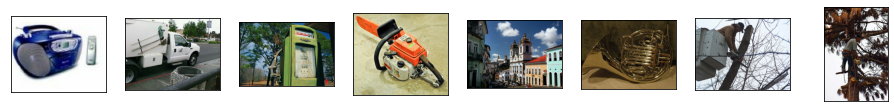

In [ ]:
some_samples = [x[0] for x in iter(train_ds.take(8))]

fig = plt.figure(figsize=(16,8))
for i in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, i + 1)
    ax.imshow(some_samples[i])
    plt.xticks([]), plt.yticks([])
plt.show()

### Build data pipeline

In [ ]:
INP_SIZE = 224
NUM_EPOCHS = 5
BATCH_SIZE = 64

In [ ]:
def convert(image, label):
    image = tf.cast(image, tf.float32)/127. - 1.
    return tf.image.resize(image, (INP_SIZE, INP_SIZE)), label

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)           
    image = tf.image.random_brightness(image, max_delta=0.5) 
    image = tf.image.random_flip_up_down(image)              

    return image,label

In [ ]:
train_ds = train_ds.map(convert)

In [ ]:
augm = train_ds.map(augment)

In [ ]:
train_ds = train_ds.concatenate(augm)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
train_ds

<DatasetV1Adapter shapes: ((64, 224, 224, 3), (64,)), types: (tf.float32, tf.int64)>

In [ ]:
test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(convert)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
test_ds

<DatasetV1Adapter shapes: ((64, 224, 224, 3), (64,)), types: (tf.float32, tf.int64)>

### Model learning MobileNetV2

In [ ]:
# Model learning

model = tf.keras.applications.MobileNetV2()

14540800/14536120 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time

history = model.fit(train_ds, 
                    epochs=NUM_EPOCHS, 
                    validation_data=test_ds)

Epoch 1/5
362/362 [==============================] - 324s 894ms/step - loss: 0.2680 - accuracy: 0.9421 - val_loss: 0.1230 - val_accuracy: 0.9648
Epoch 2/5
362/362 [==============================] - 322s 891ms/step - loss: 0.0360 - accuracy: 0.9886 - val_loss: 0.1623 - val_accuracy: 0.9594
Epoch 3/5
362/362 [==============================] - 324s 896ms/step - loss: 0.0221 - accuracy: 0.9932 - val_loss: 0.2102 - val_accuracy: 0.9555
Epoch 4/5
362/362 [==============================] - 327s 903ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.2314 - val_accuracy: 0.9547
Epoch 5/5
362/362 [==============================] - 333s 920ms/step - loss: 0.0124 - accuracy: 0.9959 - val_loss: 0.2304 - val_accuracy: 0.9547
CPU times: user 26min 15s, sys: 8min 28s, total: 34min 44s
Wall time: 27min 50s


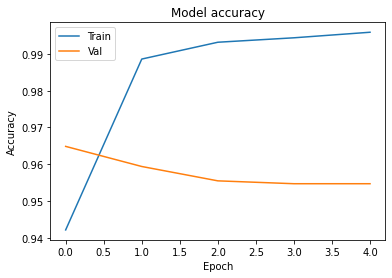

In [ ]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

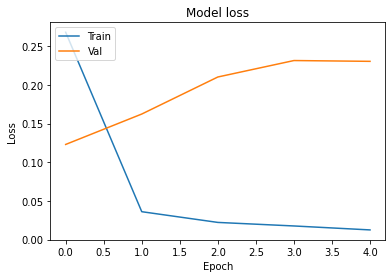

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Transfer learning

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model_tr = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model_tr.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
model_tr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
%%time

history = model_tr.fit(train_ds, 
                       epochs=NUM_EPOCHS, 
                       validation_data=test_ds)

Epoch 1/5
362/362 [==============================] - 329s 910ms/step - loss: 0.1806 - accuracy: 0.9454 - val_loss: 0.0882 - val_accuracy: 0.9758
Epoch 2/5
362/362 [==============================] - 329s 909ms/step - loss: 0.0430 - accuracy: 0.9874 - val_loss: 0.1627 - val_accuracy: 0.9648
Epoch 3/5
362/362 [==============================] - 327s 903ms/step - loss: 0.0278 - accuracy: 0.9920 - val_loss: 0.3847 - val_accuracy: 0.9320
Epoch 4/5
362/362 [==============================] - 324s 894ms/step - loss: 0.0183 - accuracy: 0.9942 - val_loss: 0.2286 - val_accuracy: 0.9633
Epoch 5/5
362/362 [==============================] - 324s 894ms/step - loss: 0.0145 - accuracy: 0.9956 - val_loss: 0.1499 - val_accuracy: 0.9742
CPU times: user 26min 10s, sys: 8min 31s, total: 34min 41s
Wall time: 27min 44s


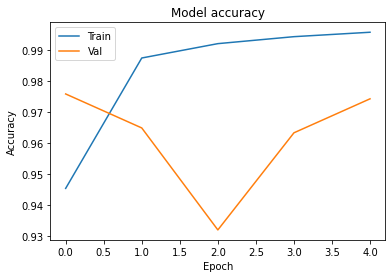

In [ ]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

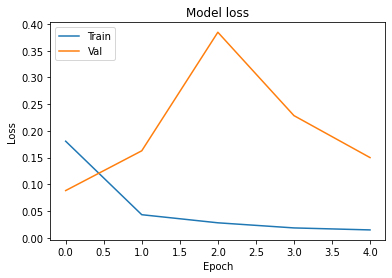

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Transfer learning (False)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [ ]:
model_tr_f = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model_tr_f.compile(optimizer=optimizer,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
model_tr_f.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
%%time

history = model_tr_f.fit(train_ds, 
                         epochs=NUM_EPOCHS, 
                         validation_data=test_ds)

Epoch 1/5
362/362 [==============================] - 143s 394ms/step - loss: 1.2760 - accuracy: 0.6065 - val_loss: 0.2274 - val_accuracy: 0.9773
Epoch 2/5
362/362 [==============================] - 146s 404ms/step - loss: 0.3033 - accuracy: 0.9229 - val_loss: 0.0750 - val_accuracy: 0.9867
Epoch 3/5
362/362 [==============================] - 148s 410ms/step - loss: 0.1843 - accuracy: 0.9479 - val_loss: 0.0523 - val_accuracy: 0.9891
Epoch 4/5
362/362 [==============================] - 149s 412ms/step - loss: 0.1487 - accuracy: 0.9549 - val_loss: 0.0401 - val_accuracy: 0.9922
Epoch 5/5
362/362 [==============================] - 146s 403ms/step - loss: 0.1296 - accuracy: 0.9604 - val_loss: 0.0353 - val_accuracy: 0.9906
CPU times: user 17min 11s, sys: 2min 17s, total: 19min 29s
Wall time: 12min 37s


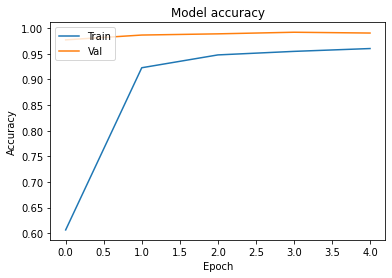

In [ ]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

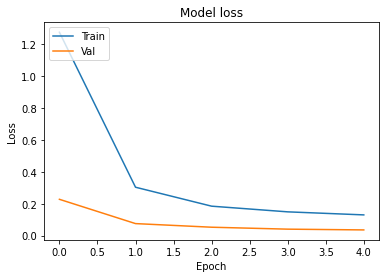

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_ds)

20/20 [==============================] - 4s 185ms/step - loss: 0.2283 - accuracy: 0.9555


[0.228325754404068, 0.9554687738418579]

In [ ]:
model_tr.evaluate(test_ds)

20/20 [==============================] - 4s 184ms/step - loss: 0.1510 - accuracy: 0.9734


[0.15103772282600403, 0.973437488079071]

In [ ]:
model_tr_f.evaluate(test_ds)

20/20 [==============================] - 4s 180ms/step - loss: 0.0352 - accuracy: 0.9906


[0.03524259105324745, 0.9906250238418579]

### Model learning ResNet50

In [ ]:
# Model learning

model_RN = tf.keras.applications.ResNet50()

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
model_RN.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model_RN.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
%%time

history = model_RN.fit(train_ds, 
                       epochs=NUM_EPOCHS, 
                       validation_data=test_ds)

Epoch 1/5
362/362 [==============================] - 542s 1s/step - loss: 0.3233 - accuracy: 0.9304 - val_loss: 2.9176 - val_accuracy: 0.4836
Epoch 2/5
362/362 [==============================] - 542s 1s/step - loss: 0.0648 - accuracy: 0.9803 - val_loss: 0.6510 - val_accuracy: 0.9055
Epoch 3/5
362/362 [==============================] - 539s 1s/step - loss: 0.0463 - accuracy: 0.9861 - val_loss: 0.6805 - val_accuracy: 0.9289
Epoch 4/5
362/362 [==============================] - 543s 2s/step - loss: 0.0389 - accuracy: 0.9884 - val_loss: 0.8241 - val_accuracy: 0.9023
Epoch 5/5
362/362 [==============================] - 543s 1s/step - loss: 0.0332 - accuracy: 0.9906 - val_loss: 0.3723 - val_accuracy: 0.9484
CPU times: user 39min 46s, sys: 12min 56s, total: 52min 43s
Wall time: 45min 46s


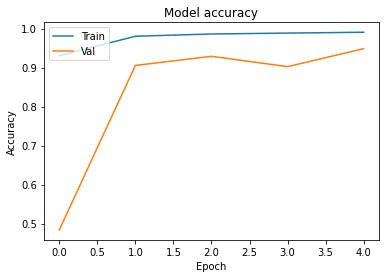

In [ ]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

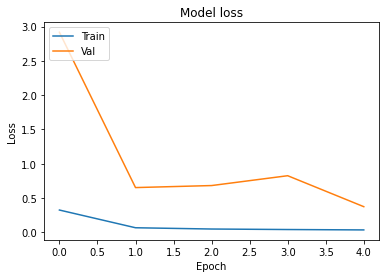

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Transfer learning

base_model = tf.keras.applications.ResNet50(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model_RN_tr = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model_RN_tr.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
model_RN_tr.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
%%time

history = model_RN_tr.fit(train_ds, 
                          epochs=NUM_EPOCHS, 
                          validation_data=test_ds)

Epoch 1/5
362/362 [==============================] - 544s 2s/step - loss: 0.2066 - accuracy: 0.9388 - val_loss: 5.8300 - val_accuracy: 0.3852
Epoch 2/5
362/362 [==============================] - 540s 1s/step - loss: 0.0744 - accuracy: 0.9788 - val_loss: 0.9975 - val_accuracy: 0.9117
Epoch 3/5
362/362 [==============================] - 540s 1s/step - loss: 0.0613 - accuracy: 0.9827 - val_loss: 1.0759 - val_accuracy: 0.9172
Epoch 4/5
362/362 [==============================] - 544s 2s/step - loss: 0.0450 - accuracy: 0.9869 - val_loss: 0.4237 - val_accuracy: 0.9547
Epoch 5/5
362/362 [==============================] - 542s 1s/step - loss: 0.0416 - accuracy: 0.9882 - val_loss: 0.9377 - val_accuracy: 0.9227
CPU times: user 39min 42s, sys: 12min 57s, total: 52min 40s
Wall time: 45min 44s


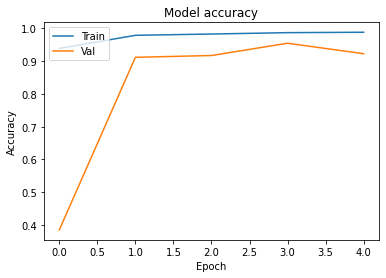

In [ ]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

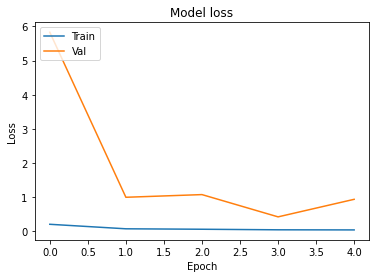

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Transfer learning (False)

base_model = tf.keras.applications.ResNet50(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [ ]:
model_RN_tr_f = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model_RN_tr_f.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
model_RN_tr_f.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
%%time

history = model_RN_tr_f.fit(train_ds, 
                            epochs=NUM_EPOCHS, 
                            validation_data=test_ds)

Epoch 1/5
362/362 [==============================] - 231s 639ms/step - loss: 2.3876 - accuracy: 0.1552 - val_loss: 2.0298 - val_accuracy: 0.3766
Epoch 2/5
362/362 [==============================] - 225s 623ms/step - loss: 2.0822 - accuracy: 0.2584 - val_loss: 1.8966 - val_accuracy: 0.4273
Epoch 3/5
362/362 [==============================] - 226s 624ms/step - loss: 1.9411 - accuracy: 0.3244 - val_loss: 1.8119 - val_accuracy: 0.4539
Epoch 4/5
362/362 [==============================] - 226s 624ms/step - loss: 1.8636 - accuracy: 0.3644 - val_loss: 1.7547 - val_accuracy: 0.4641
Epoch 5/5
362/362 [==============================] - 226s 624ms/step - loss: 1.8038 - accuracy: 0.3917 - val_loss: 1.7075 - val_accuracy: 0.4867
CPU times: user 21min 38s, sys: 4min 2s, total: 25min 40s
Wall time: 19min 19s


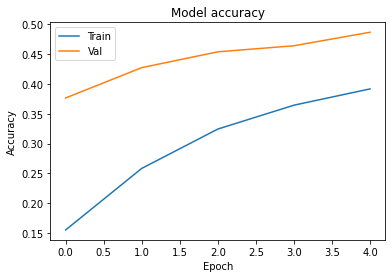

In [ ]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

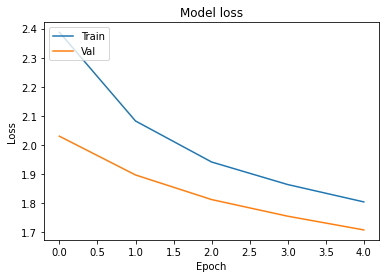

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model_RN.evaluate(test_ds)

20/20 [==============================] - 8s 378ms/step - loss: 0.3723 - accuracy: 0.9484


[0.3723163604736328, 0.948437511920929]

In [ ]:
model_RN_tr.evaluate(test_ds)

20/20 [==============================] - 7s 373ms/step - loss: 0.9318 - accuracy: 0.9234


[0.9318399429321289, 0.9234374761581421]

In [ ]:
model_RN_tr_f.evaluate(test_ds)

20/20 [==============================] - 7s 375ms/step - loss: 1.7071 - accuracy: 0.4859


[1.7070881128311157, 0.4859375059604645]

### Model learning Xception

In [ ]:
# Model learning

model_X = tf.keras.applications.Xception()

91889664/91884032 [==============================] - 1s 0us/step


In [ ]:
model_X.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model_X.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
%%time

history = model_X.fit(train_ds, 
                      epochs=NUM_EPOCHS, 
                      validation_data=test_ds)

Epoch 1/5
362/362 [==============================] - 961s 3s/step - loss: 0.3194 - accuracy: 0.9353 - val_loss: 0.0945 - val_accuracy: 0.9758
Epoch 2/5
362/362 [==============================] - 963s 3s/step - loss: 0.0308 - accuracy: 0.9912 - val_loss: 0.0990 - val_accuracy: 0.9766
Epoch 3/5
362/362 [==============================] - 963s 3s/step - loss: 0.0181 - accuracy: 0.9945 - val_loss: 0.0778 - val_accuracy: 0.9781
Epoch 4/5
362/362 [==============================] - 959s 3s/step - loss: 0.0141 - accuracy: 0.9956 - val_loss: 0.1356 - val_accuracy: 0.9742
Epoch 5/5
362/362 [==============================] - 962s 3s/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.1016 - val_accuracy: 0.9789
CPU times: user 59min 15s, sys: 27min 49s, total: 1h 27min 4s
Wall time: 1h 20min 49s


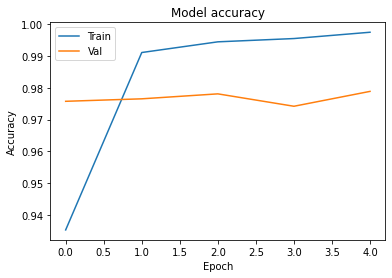

In [ ]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

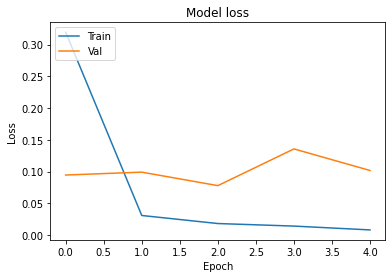

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Transfer learning

base_model = tf.keras.applications.Xception(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
model_X_tr = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model_X_tr.compile(optimizer=optimizer,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
model_X_tr.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20490     
Total params: 20,881,970
Trainable params: 20,827,442
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
%%time

history = model_X_tr.fit(train_ds, 
                         epochs=NUM_EPOCHS, 
                         validation_data=test_ds)

Epoch 1/5
362/362 [==============================] - 965s 3s/step - loss: 0.1646 - accuracy: 0.9597 - val_loss: 0.0663 - val_accuracy: 0.9812
Epoch 2/5
362/362 [==============================] - 965s 3s/step - loss: 0.0276 - accuracy: 0.9926 - val_loss: 0.0593 - val_accuracy: 0.9828
Epoch 3/5
362/362 [==============================] - 964s 3s/step - loss: 0.0156 - accuracy: 0.9954 - val_loss: 0.0928 - val_accuracy: 0.9820
Epoch 4/5
362/362 [==============================] - 959s 3s/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.0817 - val_accuracy: 0.9836
Epoch 5/5
362/362 [==============================] - 961s 3s/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.0982 - val_accuracy: 0.9805
CPU times: user 59min 12s, sys: 27min 53s, total: 1h 27min 6s
Wall time: 1h 20min 49s


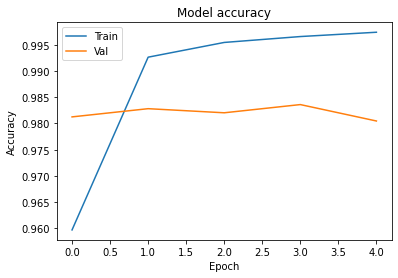

In [ ]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

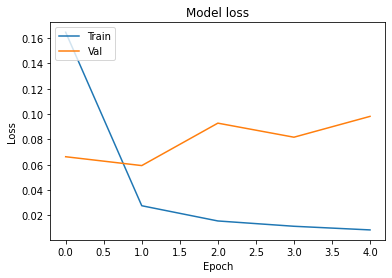

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Transfer learning (False)

base_model = tf.keras.applications.Xception(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [ ]:
model_X_tr_f = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model_X_tr_f.compile(optimizer=optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
model_X_tr_f.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                20490     
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
%%time

history = model_X_tr_f.fit(train_ds, 
                           epochs=NUM_EPOCHS, 
                           validation_data=test_ds)

Epoch 1/5
362/362 [==============================] - 318s 878ms/step - loss: 0.8614 - accuracy: 0.7990 - val_loss: 0.1517 - val_accuracy: 0.9883
Epoch 2/5
362/362 [==============================] - 319s 880ms/step - loss: 0.2019 - accuracy: 0.9550 - val_loss: 0.0725 - val_accuracy: 0.9867
Epoch 3/5
362/362 [==============================] - 316s 873ms/step - loss: 0.1410 - accuracy: 0.9630 - val_loss: 0.0557 - val_accuracy: 0.9867
Epoch 4/5
362/362 [==============================] - 318s 880ms/step - loss: 0.1230 - accuracy: 0.9652 - val_loss: 0.0482 - val_accuracy: 0.9898
Epoch 5/5
362/362 [==============================] - 317s 874ms/step - loss: 0.1106 - accuracy: 0.9678 - val_loss: 0.0446 - val_accuracy: 0.9875
CPU times: user 25min 19s, sys: 7min 45s, total: 33min 5s
Wall time: 26min 52s


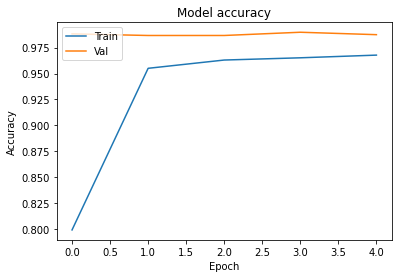

In [ ]:
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

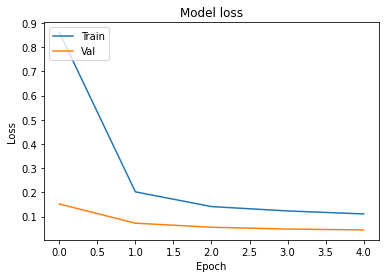

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model_X.evaluate(test_ds)

20/20 [==============================] - 12s 595ms/step - loss: 0.1016 - accuracy: 0.9789


[0.10164108127355576, 0.9789062738418579]

In [ ]:
model_X_tr.evaluate(test_ds)

20/20 [==============================] - 12s 590ms/step - loss: 0.0955 - accuracy: 0.9812


[0.09547745436429977, 0.981249988079071]

In [ ]:
model_X_tr_f.evaluate(test_ds)

20/20 [==============================] - 12s 589ms/step - loss: 0.0445 - accuracy: 0.9875


[0.044503308832645416, 0.987500011920929]

## Best test score

In [ ]:
# MobileNetV2 

model_tr_f.evaluate(test_ds)

20/20 [==============================] - 4s 181ms/step - loss: 0.0353 - accuracy: 0.9906


[0.035314369946718216, 0.9906250238418579]

In [ ]:
# ResNet50 

model_RN.evaluate(test_ds)

20/20 [==============================] - 7s 375ms/step - loss: 0.3720 - accuracy: 0.9484


[0.3720285892486572, 0.948437511920929]

In [ ]:
# Xception

model_X_tr_f.evaluate(test_ds)

20/20 [==============================] - 12s 593ms/step - loss: 0.0448 - accuracy: 0.9875


[0.04478055611252785, 0.987500011920929]

### Выводы:

По результатам обучения моделей в нашем эксперименте можно сделать следующие основные выводы:


*   очевидно, что необходимо учитывать архитектуру нейронной сети, так как в случае обучения моделей ResNet50 применение TL привело к ухудшению результатов обучения, хотя учитывая динамику минизации loss, привиденную на графиках, вполне вероятно, что при гораздо большем количестве эпох обучения результаты могут быть улучшенны;
*   применение метода Transfer learning позволило улучшить результаты обучения для моделей нейронных сетей архитектур MobileNetV2 и Xception;
*   лучшие результаты для Transfer learning были получены с флагом False для метода .trainable, что говорит о том что веса (weights='imagenet') имеют более точное распределение по сравнению с весами, которые мы получаем в ходе дообучения модели с флагом True или обучения моделей с нуля на новом датасете;
*   применение Transfer learning уменьшает время обучения сети.

И как общий вывод, можно уверенно утверждать, что применение метода Transfer learning при обучении моделей сверточных нейронных сетей целесообразно, позволяет получать более высокие значения метрики accuracy и за меньшее время.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

2. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

**Natural- To Formal-Language Generation Using Tensor Product Representations**

Авторы статьи: Kezhen Chen, Qiuyuan Huang, Hamid Palangi, Paul Smolensky, Kenneth D. Forbus, Jianfeng Gao (USA, 2019).

*   https://arxiv.org/abs/1910.02339 - оригинал статьи;
*   https://github.com/ckzbullbullet/TP-N2F - код на GitHub.

Исследователи из компании Майкрософт предлагают модель кодера-декодера на основе представлений в виде тензорных произведений для перевода естественного языка в формальный.

Кодер использует представления в виде тензорных произведений для погружения символических структур некоторой формальной задачи, сформулированной на естественном языке, в линейное векторное пространство. На основе этих векторных представлений декодер, по сути, генерирует символическую формулу/программу, решающую поставленную задачу. Авторам удалось существенно превзойти результаты ранее существовавших моделей на основе долгой краткосрочной памяти (LSTM) и показать передовые результаты в решении математических задач на основе набора данных MathQA и синтезе программ на основе набора данных AlgoLisp.

Каждому входному токену в кодере назначается вектор "роли" и вектор "исполнителя роли", выбираемые из соответствующих обучаемых словарей. Назначение основывается на гипотезе о том, что векторы "роли" и "исполнителя" аппроксимируют грамматическую роль и лексическую семантику слова соответственно.

Выбор этих векторов осуществляется парой модулей, каждый из которых состоит из ячейки долгой краткосрочной памяти и двух последующих линейных слоёв, соединённых функцией мягкого максимума и отображающих скрытое состояние ячейки в соответствующий вектор. Каждый токен представляется в виде тензорного произведения двух таких векторов.

При этом, помимо самого набора таких произведений, который в дальнейшем выполняет роль контекста для механизма внимания, всё предложение в целом представляется также в виде их суммы, которая с помощью многослойного персептрона кодируется в начальное скрытое состояние ячейки долгой краткосрочной памяти декодера.

На каждом шаге новое скрытое состояние ячейки долгой краткосрочной памяти декодера подаётся на вход механизма внимания со скалярным произведением в роли оценивающей функции и набором тензорных произведений векторов "ролей" и "исполнителей" в роли контекста. Выходной вектор передаётся на вход специального модуля, который расценивает его (вектор) так, как если бы он являлся представлением в виде тензорного произведения некоторого отношения с фиксированным набором аргументов.

Используя обучаемые структуры для вычленения позиций, отношения и аргументов из такого гипотетического представления, этот модуль выбирает наиболее вероятные символы для отношения и его аргументов, и выдаёт их на выход.

Такая модель, обученная с использованием метода адаптивной оценки моментов с педагогическим принуждением и перекрёстной энтропией в качестве функции потерь, показала на наборе данных MathQA точность операций/численных результатов, равную 71.89% и 55.95% соответственно. В задаче синтеза программ на наборе данных AlgoLisp также обученная модель показала точность 84.02% и 93.48% на полном и очищенном наборах тестов соответственно.